In [2]:
import corr

import numpy as np
import matplotlib.pyplot as plt

In [3]:
frames = corr.load_example_experiment()

In [4]:
frames = np.array(frames)
print(frames.shape)

(764, 258, 512)


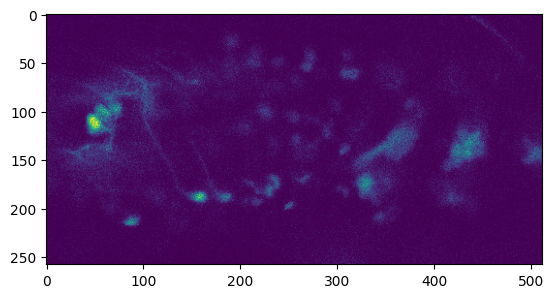

In [4]:
plt.imshow(frames[0])

In [45]:
def get_neighbor_coords(image: np.ndarray, x: int, y: int) -> list[tuple[int, int]]:
    H, W = image.shape[0], image.shape[1]
    x_neighbors = [-1, 0, 1]
    y_neighbors = [-1, 0, 1]
    neighbor_coords = []
    for dx in x_neighbors:
        for dy in y_neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < W and 0 <= ny < H:
                if not (dx == 0 and dy == 0):
                    neighbor_coords.append((nx, ny))
    return neighbor_coords


In [30]:
def get_corr_with_neighbors(image_stack: np.ndarray, x: int, y:int) -> float:
    """
    :param image_stack: (N, H, W) array of N timepoints of HxW images
    :param x: x coordinate of the pixel
    :param y: y coordinate of the pixel
    """
    neighbor_coords = get_neighbor_coords(image_stack[0], x, y)

    pixel_fl_time_series = image_stack[:, y, x]
    neighbors_fl_time_series = np.stack([image_stack[:, ny, nx] for nx, ny in
                                         neighbor_coords], axis=1)
    neighbors_mean_time_series = neighbors_fl_time_series.mean(axis=1)
    corr = np.corrcoef(pixel_fl_time_series, neighbors_mean_time_series)[0, 1]
    return corr

In [31]:
corr_test_pixel = get_corr_with_neighbors(frames, 0, 0)
print(corr_test_pixel)

0.0037697700534692065


In [34]:
def calculate_all_corrs(image_stack: np.ndarray) -> np.ndarray:
    H, W = image_stack.shape[1], image_stack.shape[2]
    corrs = np.zeros_like(image_stack[0])
    for x in range(W):
        for y in range(H):
            corr = get_corr_with_neighbors(image_stack, x, y)
            corrs[y, x] = corr
    return corrs

In [35]:
corrs = calculate_all_corrs(frames)

In [36]:
corrs

array([[ 0.00376977, -0.00527079,  0.01217563, ...,  0.00880214,
         0.06491039,  0.0410328 ],
       [-0.02681739,  0.01407238,  0.04044422, ...,  0.01840975,
         0.03304483,  0.04788852],
       [ 0.00211562,  0.05637931,  0.0524962 , ...,  0.01440224,
        -0.00680388, -0.00384664],
       ...,
       [ 0.06767803,  0.02644422,  0.15441577, ...,  0.08533323,
         0.02569029,  0.06833686],
       [ 0.10094995,  0.06612404,  0.11633337, ...,  0.16354613,
         0.15822726,  0.12278126],
       [ 0.03926997,  0.09740493,  0.07800642, ...,  0.16462794,
         0.1670154 ,  0.10127743]], dtype=float32)

In [37]:
np.argmax(corrs)

108119

In [38]:
np.max(corrs)

0.9925112

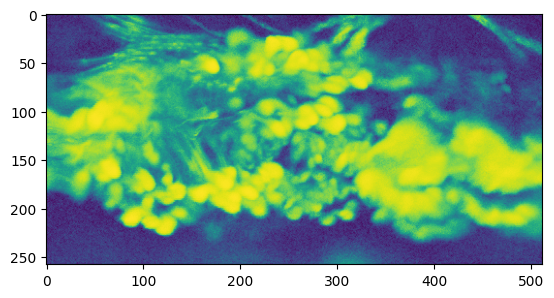

In [39]:
plt.imshow(corrs)

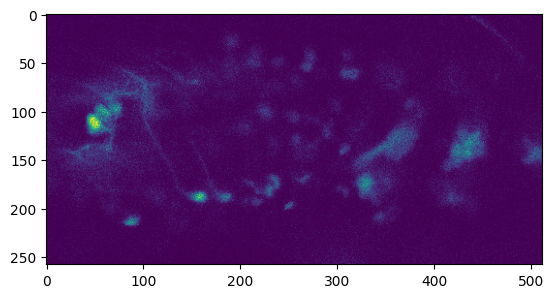

In [40]:
plt.imshow(frames[0])

In [73]:
def build_rois(corrs: np.ndarray, threshhold=0.0) -> np.ndarray:
    corrs_cpy = corrs.copy()
    rois = []
    for i in range(3):  # building three rois
        roi = []
        center = np.unravel_index(np.argmax(corrs_cpy, axis=None), corrs_cpy.shape)
        roi.append(center)
        corrs_cpy[center] = 0
        neighbors = get_neighbor_coords(corrs_cpy, center[0], center[1])
        for x, y in neighbors:
            if corrs_cpy[y, x] > threshhold:
                roi.append((x, y))
                corrs_cpy[y, x] = 0
        rois.append(roi)
    return rois

In [ ]:
def build_roi_recursive(corrs: np.ndarray, center_x, center_y, threshhold=0.0,
                        visited: set = set()) ->np.ndarray:
    center = (center_x, center_y)
    if center in visited or corrs[center] < threshhold:
        return set()
    visited.add(center)

    roi = {center}
    neighbors = get_neighbor_coords(corrs, center_x, center_y)
    for x, y in neighbors:
        if corrs[y, x] > threshhold:
            roi.update(build_roi_recursive(corrs, x, y, threshhold, visited))

    return roi

In [74]:
rois = build_rois(corrs)


In [75]:
print(rois)

[[(211, 87), (210, 86), (210, 87), (210, 88), (211, 86), (211, 88), (212, 86), (212, 87), (212, 88)], [(210, 88), (209, 87), (209, 88), (209, 89), (210, 89), (211, 87), (211, 89)], [(211, 89), (210, 90), (211, 90), (212, 89), (212, 90)]]


In [76]:
print(len(rois[0]))

9


In [77]:
def plot_blobs_on_image(image, blobs, color='r', marker='o'):
    """
    Overlays blobs on an image.

    :param image: 2D NumPy array representing the background image.
    :param blobs: List of blobs, each blob is a list of (y, x) coordinate tuples.
    :param color: Color of the blob markers.
    :param marker: Marker style for blob points (default is 'o').
    """
    plt.imshow(image, cmap='gray')
    for blob in blobs:
        y_coords, x_coords = zip(*blob)
        plt.plot(x_coords, y_coords, marker=marker, linestyle='None', color=color)
    plt.title("Blobs on Image")
    plt.axis('off')
    plt.show()

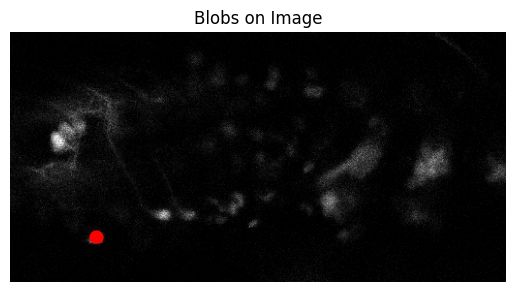

In [78]:
plot_blobs_on_image(frames[0], rois)